In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

%matplotlib inline

In [14]:
path_ = '../data/db_bsm_financial.csv'

In [15]:
data_ = pd.read_csv(path_)
data_['date'] = pd.to_datetime(data_['date'])
data_filt = data_[['ticker', 'date', 'close', 'volume']].sort_values(['ticker', 'date'], ascending=[True, True]).reset_index(drop=True)

In [89]:
data_filt['close'] = data_filt['close'].replace(0, np.NaN)
for tick in data_filt['ticker'].unique():
    data_filt.loc[data_filt['ticker'] == tick, 'close'] = data_filt[data_filt['ticker'] == tick]['close'].interpolate()

In [92]:
def add_pl(df_, col_id, col_calc_pl):
    for id_ in df_[col_id].unique():
        df_by_id = df_[df_[col_id] == id_]
        df_.loc[df_[col_id] == id_, 'daily_pl'] = df_by_id[col_calc_pl] - df_by_id[col_calc_pl].shift(1)
    return df_

data_filt = add_pl(data_filt, 'ticker', 'close')

In [93]:
data_filt = data_filt.dropna()

In [94]:
data_filt.isna().sum()

ticker      0
date        0
close       0
volume      0
daily_pl    0
dtype: int64

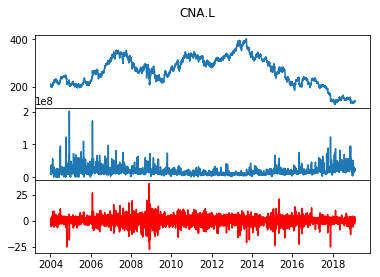

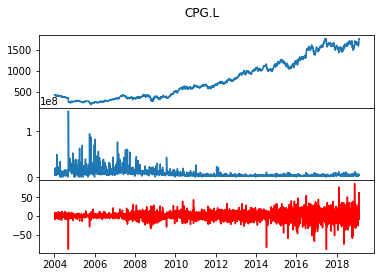

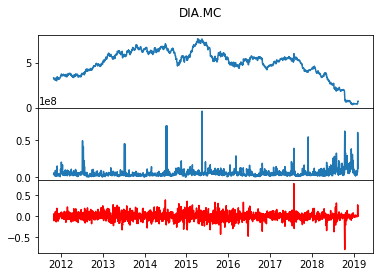

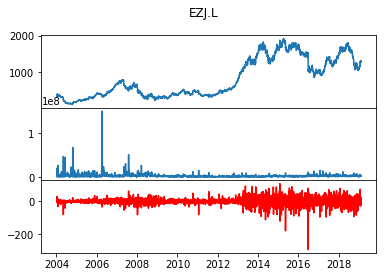

In [98]:
for tick in data_filt['ticker'].unique():
    df_ = data_filt[data_filt['ticker'] == tick]
    f, axarr = plt.subplots(3, sharex=True, sharey=False)
    f.suptitle(tick)
    axarr[0].plot(df_['date'], df_['close'])
    axarr[1].plot(df_['date'], df_['volume'])
    axarr[2].plot(df_['date'], df_['daily_pl'], color='r')
    # Bring subplots close to each other.
    f.subplots_adjust(hspace=0)
    # Hide x labels and tick labels for all but bottom plot.
    for ax in axarr:
        ax.label_outer()